In [1]:
## 20180905 runs PD logistic regression models for all banks
## 20170519 modified to product logistic PDs for 2015 and 2016 quarters
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta  ## use this to increment targ by 1 year!!!!
import time
from time import gmtime, strftime

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
#import random

import sys
import os
os.chdir('C:/BankRisk')

In [2]:
rk = pd.read_csv("BkAvgAstPR_FailDate_BHC2_ult201806.csv", index_col=0)  # ultcert version
rk['xAsOf'] = pd.to_datetime(rk['xAsOf'])
rk['nAsOf'] = pd.to_datetime(rk['nAsOf'])
rk['FailDate'] = pd.to_datetime(rk['FailDate'])
rk.tail(3)

Rank   IDRSSD      xAsOf                                        xName  \
10769  10770  2809355 2002-09-30             FIRST TRUST COMPANY OF ONAGA, NA   
10770  10771  3037904 2002-06-30  MARQUETTE TRUST COMPANY OF SOUTH DAKOTA, NA   
10771  10772  3874891 2008-12-31          TEXAS FIRST BANK - RETAINED CHARTER   

      xState    xCert      nAsOf FailDate BkClass  Offices     ...      \
10769     KS  35589.0 2001-03-31      NaT     NaN      NaN     ...       
10770     SD  57326.0 2001-12-31      NaT     NaN      NaN     ...       
10771     TX  21960.0 2008-12-31      NaT      NM      1.0     ...       

      aeTotLn  aeDDep aeFDep  aeTotDep        pr_eTA    pr_eTAcs  pr_eTL  \
10769     0.0     0.0    0.0       0.0  4.411294e-06   99.999998     0.0   
10770     0.0     0.0    0.0       0.0  1.839238e-06  100.000000     0.0   
10771     0.0    66.0    0.0      66.0  4.152441e-07  100.000000     0.0   

       pr_eTLcs        pr_eDD    pr_eDDcs  
10769     100.0  0.000000e+00  108.569224  
10770     100.0  0.000000e+00  108.569224  
10771     100.0  7.292320e-07  108.569225  

[3 rows x 27 columns]

In [3]:
dfz = pd.read_csv("df3z_201806_allbanks.csv") # 20160521 update
dfz['AsOf'] = pd.to_datetime(dfz['AsOf'])
#dfz = dfz[dfz['AsOf']<='2014-12-31']  # does not work if AsOf > 2014-12-31 (this has been fixed: 20170519)
dfcol = list(dfz.columns)
dfz.columns

Index([u'Unnamed: 0', u'IDRSSD', u'AsOf', u'Name', u'State', u'Cert',
       u'eTotAst', u'qNetInc', u'qNetII', u'qProv',
       ...
       u'eTotrb', u'eALLL_Ln', u'mxCx', u'mxSfFst', u'mxCRE', u'mxCI',
       u'mxCard', u'mxDDA', u'eRWA_TA', u'lnTotAst'],
      dtype='object', length=134)

In [4]:
len(dfz) # 515693

515693

In [5]:
rk[0:5]

Rank  IDRSSD      xAsOf                    xName xState    xCert  \
0     1  852218 2018-06-30  JPMORGAN CHASE BANK, NA     OH    628.0   
1     2  480228 2018-06-30      BANK OF AMERICA, NA     NC   3510.0   
2     3  476810 2018-06-30           CITIBANK, N.A.     SD   7213.0   
3     4  451965 2018-06-30     WELLS FARGO BANK, NA     SD   3511.0   
4     5  484422 2009-12-31        WACHOVIA BANK, NA     NC  33869.0   

       nAsOf   FailDate BkClass  Offices    ...           aeTotLn  \
0 2001-03-31        NaT       N   5202.0    ...      5.103033e+08   
1 2001-03-31 2009-01-16       N   4488.0    ...      6.572162e+08   
2 2001-03-31 2008-11-23       N    716.0    ...      5.043212e+08   
3 2001-03-31        NaT       N   5912.0    ...      5.267557e+08   
4 2001-03-31        NaT       N   3312.0    ...      2.546369e+08   

         aeDDep        aeFDep      aeTotDep    pr_eTA   pr_eTAcs    pr_eTL  \
0  6.666457e+08  2.535391e+08  9.201849e+08  9.193848   9.193848  5.638326   
1  7.949126e+08  1.059607e+08  9.008733e+08  7.896924  17.090772  7.261562   
2  2.793764e+08  4.392890e+08  7.186653e+08  6.626980  23.717752  5.572229   
3  6.019828e+08  6.760383e+07  6.695866e+08  5.475375  29.193127  5.820108   
4  2.704156e+08  2.469325e+07  2.951088e+08  2.778653  31.971779  2.813476   

    pr_eTLcs    pr_eDD   pr_eDDcs  
0   5.638326  7.365749   7.365749  
1  12.899888  8.782965  16.148713  
2  18.472117  3.086821  19.235534  
3  24.292225  6.651290  25.886824  
4  27.105701  2.987814  28.874638  

[5 rows x 27 columns]

In [6]:
dfcol[-56:][0:5]  ## want to start with rcTotLn as first of all ratios

['rcTotLn', 'rcCx', 'rcSfRev', 'rcSfTD', 'rcMult']

In [7]:
xcol=['rcTotLn','qnTotLn','rNIM','rPPNR','rROA','rROE','rEff','eLn_Dep','aFF_TA','eBrok_Dep','eT1rb','eTotrb','eALLL_Ln','lnTotAst']
#xcol=['rcTotLn','qnTotLn','rNIM','rPPNR','rROA','rROE','rEff','eLn_Dep','aFF_TA','eT1rb','eTotrb','eALLL_Ln','lnTotAst']
xcol

['rcTotLn',
 'qnTotLn',
 'rNIM',
 'rPPNR',
 'rROA',
 'rROE',
 'rEff',
 'eLn_Dep',
 'aFF_TA',
 'eBrok_Dep',
 'eT1rb',
 'eTotrb',
 'eALLL_Ln',
 'lnTotAst']

In [8]:
#dfz['AsOf'] = pd.to_datetime(dfz['AsOf'])
dfr = dfz[dfz['AsOf']>='2001-12-31'][['IDRSSD','AsOf','Name','State','eTotAst']+xcol]

In [9]:
dfr.tail(2)

IDRSSD       AsOf              Name State  eTotAst  rcTotLn  qnTotLn  \
515691  5205819 2018-06-30       STUDIO BANK    TN  45553.0      NaN      0.0   
515692  5227101 2018-06-30  COMMERCEONE BANK    AL  56804.0      NaN      0.0   

        rNIM  rPPNR  rROA  rROE  rEff    eLn_Dep     aFF_TA  eBrok_Dep  \
515691   NaN    NaN   NaN   NaN   NaN   0.000000  99.591371        0.0   
515692   NaN    NaN   NaN   NaN   NaN  25.223759  87.809020        0.0   

              eT1rb       eTotrb  eALLL_Ln   lnTotAst  
515691  3613.001605  3613.001605  0.000000  10.726632  
515692   631.053902   631.402521  1.198157  10.947362

In [10]:
len(dfr) # 489288

489288

In [11]:
## add faildate (if it hasn't already been added):
if 'FailDate' not in list(dfr.columns): dfr = dfr.merge(rk[['IDRSSD','FailDate']],how='left',on='IDRSSD')

In [12]:
## calculate months-to-fail (mtf) and fail flags (f6 and f12):
dfr['mtf'] = ((dfr['FailDate'] - dfr['AsOf'])/np.timedelta64(1,'M')) 
dfr['mtf2'] = dfr.apply(lambda x: round(x['mtf'],0),axis=1)
dfr['f2'] = ((dfr['mtf'] <= 6.0) & (dfr['mtf'] >= 0.0))*1
dfr['f4'] = ((dfr['mtf'] <= 12.0) & (dfr['mtf'] >= 0.0))*1
dfr['f6'] = ((dfr['mtf'] <= 18.0) & (dfr['mtf'] >= 0.0))*1
dfr['f8'] = ((dfr['mtf'] <= 24.0) & (dfr['mtf'] >= 0.0))*1
dfr[dfr['FailDate']>'1990'].tail(10)

IDRSSD       AsOf                   Name State  eTotAst    rcTotLn  \
484831  3640854 2010-12-31  PISGAH COMMUNITY BANK    NC  42376.0  28.150487   
484832  3640854 2011-03-31  PISGAH COMMUNITY BANK    NC  37254.0   8.929288   
484833  3640854 2011-06-30  PISGAH COMMUNITY BANK    NC  30273.0   8.503535   
484834  3640854 2011-09-30  PISGAH COMMUNITY BANK    NC  30326.0   6.575220   
484835  3640854 2011-12-31  PISGAH COMMUNITY BANK    NC  28120.0   1.430248   
484836  3640854 2012-03-31  PISGAH COMMUNITY BANK    NC  27152.0   2.384150   
484837  3640854 2012-06-30  PISGAH COMMUNITY BANK    NC  27272.0   3.607183   
484838  3640854 2012-09-30  PISGAH COMMUNITY BANK    NC  27126.0   2.767538   
484839  3640854 2012-12-31  PISGAH COMMUNITY BANK    NC  24844.0   3.571429   
484840  3640854 2013-03-31  PISGAH COMMUNITY BANK    NC  21880.0   4.476975   

          qnTotLn      rNIM     rPPNR       rROA ...    eTotrb   eALLL_Ln  \
484831  23.925972  1.477079 -1.921769 -18.226779 ...  1.820415   4.658121   
484832  17.008591  1.501112 -3.117728 -10.539127 ...  4.962240   9.265289   
484833  21.446963  1.627686 -4.269489 -10.664828 ...  4.205588   9.130049   
484834  22.193740  1.812781 -5.113951 -11.027282 ...  3.881005   8.688613   
484835  18.812332  2.028930 -6.126587  -9.089617 ...  4.278839   9.745355   
484836  25.039539  2.097654 -6.350320  -6.577475 ...  4.561760  10.918437   
484837  24.826110  2.210453 -7.173657  -7.180697 ...  4.254765   8.768801   
484838  30.337148  2.105704 -7.160776  -7.164372 ...  4.221197   8.890119   
484839  20.492884  1.927205 -7.261747  -7.265452 ...  4.766264   9.330094   
484840  19.035231  1.919126 -6.838070  -5.395423 ...  5.006596   6.525940   

         lnTotAst   FailDate        mtf  mtf2  f2  f4  f6 f8  
484831  10.654337 2013-05-10  28.288055  28.0   0   0   0  0  
484832  10.525515 2013-05-10  25.331116  25.0   0   0   0  0  
484833  10.318012 2013-05-10  22.341321  22.0   0   0   0  1  
484834  10.319761 2013-05-10  19.318672  19.0   0   0   0  1  
484835  10.244236 2013-05-10  16.296023  16.0   0   0   1  1  
484836  10.209206 2013-05-10  13.306228  13.0   0   0   1  1  
484837  10.213616 2013-05-10  10.316434  10.0   0   1   1  1  
484838  10.208248 2013-05-10   7.293784   7.0   0   1   1  1  
484839  10.120372 2013-05-10   4.271135   4.0   1   1   1  1  
484840   9.993328 2013-05-10   1.314195   1.0   1   1   1  1  

[10 rows x 26 columns]

In [13]:
dfr[dfr['FailDate']>'1990'][['AsOf','IDRSSD','FailDate','mtf','mtf2']].tail(10)

AsOf   IDRSSD   FailDate        mtf  mtf2
484831 2010-12-31  3640854 2013-05-10  28.288055  28.0
484832 2011-03-31  3640854 2013-05-10  25.331116  25.0
484833 2011-06-30  3640854 2013-05-10  22.341321  22.0
484834 2011-09-30  3640854 2013-05-10  19.318672  19.0
484835 2011-12-31  3640854 2013-05-10  16.296023  16.0
484836 2012-03-31  3640854 2013-05-10  13.306228  13.0
484837 2012-06-30  3640854 2013-05-10  10.316434  10.0
484838 2012-09-30  3640854 2013-05-10   7.293784   7.0
484839 2012-12-31  3640854 2013-05-10   4.271135   4.0
484840 2013-03-31  3640854 2013-05-10   1.314195   1.0

In [14]:
## issues:  Ln_Dep, Brok_Dep ratios:
dfr[['eLn_Dep','aFF_TA','eBrok_Dep','eALLL_Ln']].max()

eLn_Dep      1.188277e+08
aFF_TA       1.242405e+03
eBrok_Dep    7.002056e+03
eALLL_Ln     1.500000e+04
dtype: float64

In [15]:
dfr.ix[dfr['eLn_Dep'].idxmax()]

IDRSSD                               3376461
AsOf                     2005-09-30 00:00:00
Name         LEHMAN BROTHERS COMMERCIAL BANK
State                                     UT
eTotAst                          1.32523e+06
rcTotLn                                  NaN
qnTotLn                                    0
rNIM                                     NaN
rPPNR                                    NaN
rROA                                     NaN
rROE                                     NaN
rEff                                     NaN
eLn_Dep                          1.18828e+08
aFF_TA                               3.85946
eBrok_Dep                                  0
eT1rb                                15.0255
eTotrb                               15.0255
eALLL_Ln                                   0
lnTotAst                             14.0971
FailDate                                 NaT
mtf                                      NaN
mtf2                                     NaN
f2        

In [16]:
## Don't run this unless something has changed!!!!!!!!!
dfr.to_csv("logistic_rawdata.csv")

In [17]:
len(dfr) # 489288

489288

In [18]:
dfr.columns

Index([u'IDRSSD', u'AsOf', u'Name', u'State', u'eTotAst', u'rcTotLn',
       u'qnTotLn', u'rNIM', u'rPPNR', u'rROA', u'rROE', u'rEff', u'eLn_Dep',
       u'aFF_TA', u'eBrok_Dep', u'eT1rb', u'eTotrb', u'eALLL_Ln', u'lnTotAst',
       u'FailDate', u'mtf', u'mtf2', u'f2', u'f4', u'f6', u'f8'],
      dtype='object')

In [19]:
## curr date is 2010-12-31, but cut off dataset at 2009-12-31, then adjust for any fail flags later than 2010-12-31:
targ = pd.to_datetime('2009-12-31')
thresh = 0
alt = 'roe' ## or alt = ''  # add rROE >=-200 screening test
dfh = dfr[(dfr['AsOf']<=targ)][['IDRSSD','AsOf','Name','FailDate','f2','f4','f6','f8']+xcol]
#dfr09 = sm.add_constant(dfr09)
len(dfh) # 265388

265388

In [20]:
dfh.columns[8:]

Index([u'rcTotLn', u'qnTotLn', u'rNIM', u'rPPNR', u'rROA', u'rROE', u'rEff',
       u'eLn_Dep', u'aFF_TA', u'eBrok_Dep', u'eT1rb', u'eTotrb', u'eALLL_Ln',
       u'lnTotAst'],
      dtype='object')

In [21]:
dfh[['eLn_Dep','aFF_TA','eBrok_Dep','eALLL_Ln']].max()

eLn_Dep      1.188277e+08
aFF_TA       1.242405e+03
eBrok_Dep    7.002056e+03
eALLL_Ln     1.500000e+04
dtype: float64

In [22]:
## screening criteria, remove outliers: (10/29/15 add eT1rb and lnTotAst screens)
dfh.dropna(how='any',inplace=True,subset=dfh.columns[8:])  # delete any ratio columns with NaN values (note columns[8:])
dfh= dfh[dfh['eLn_Dep']<=1000]
dfh= dfh[dfh['eBrok_Dep']<=100]
dfh= dfh[dfh['eALLL_Ln']<=100]
dfh= dfh[dfh['rROE']>=-200]
dfh= dfh[dfh['eT1rb']<=200]   # added 10/29/15
dfh= dfh[dfh['lnTotAst']>=2]  # added 10/29/15
len(dfh) # 259210

259210

In [23]:
# 20160428 handles leap years now.
targ2 = pd.to_datetime(targ.day + targ.month*100 + (targ.year + 1)*10000,format='%Y%m%d')
targ2, targ

(Timestamp('2010-12-31 00:00:00'), Timestamp('2009-12-31 00:00:00'))

In [24]:
## set fflags to zero if FailDate after target date (12/31/2009); that is, for f4
dfh.ix[dfh.FailDate>targ2,['f2','f4','f6','f8']] = [0,0,0,0]

In [25]:
dfh.ix[(dfh.FailDate>'2010-09-01')&(dfh.FailDate<'2012-01-01')&(dfh.AsOf>'2009-09-01'),\
       ['IDRSSD','AsOf','Name','FailDate','f2','f4','f6','f8']].head()

IDRSSD       AsOf                 Name   FailDate  f2  f4  f6  f8
5637   16337 2009-09-30         WAKULLA BANK 2010-10-01   0   0   1   1
5638   16337 2009-12-31         WAKULLA BANK 2010-10-01   0   1   1   1
7251   20370 2009-09-30  FIRST HERITAGE BANK 2011-05-27   0   0   0   0
7252   20370 2009-12-31  FIRST HERITAGE BANK 2011-05-27   0   0   0   0
8406   23241 2009-09-30      INTEGRA BANK NA 2011-07-29   0   0   0   0

In [26]:
## regressions:
fml = 'f4 ~ ' + ' + '.join(xcol)
fml

'f4 ~ rcTotLn + qnTotLn + rNIM + rPPNR + rROA + rROE + rEff + eLn_Dep + aFF_TA + eBrok_Dep + eT1rb + eTotrb + eALLL_Ln + lnTotAst'

In [27]:
try:
  md = smf.logit(formula=fml, data=dfh).fit()
  print(md.summary())
except:
  print("Full model didn't work")

Optimization terminated successfully.
         Current function value: 0.010300
         Iterations 16
                           Logit Regression Results                           
Dep. Variable:                     f4   No. Observations:               259210
Model:                          Logit   Df Residuals:                   259195
Method:                           MLE   Df Model:                           14
Date:                Mon, 15 Oct 2018   Pseudo R-squ.:                  0.5637
Time:                        07:55:56   Log-Likelihood:                -2670.0
converged:                       True   LL-Null:                       -6119.4
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.8273      0.442    -10.916      0.000      -5.694      -3.961
rcTotLn       -0.0586      0

In [28]:
## stepwise regressions:
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

## create 2-var models:
topx = 2
def dv1_topx(group):
  return group.sort_index(by='r1', ascending=False)[:topx]

dv1 = pd.DataFrame(columns=['fx','v1', 'r1']) # c1: category1, v1: variable1, r1: rsquared1
for fx in ['f2','f4','f6']:
  for v in xcol:
    y, X = dmatrices( fx + ' ~ ' + v , data=dfh, return_type='dataframe')
    try:
      res = sm.Logit(y, X).fit()
      dv1 = dv1.append({'fx': fx,'v1': v, 'r1': res.prsquared}, ignore_index=True)
    except:
      pass

dv1g = dv1.groupby(['fx'])
dv1t = dv1g.apply(dv1_topx)
dv1t.index = np.arange(len(dv1t))

# stores r-sq values for all 2-var combos:
dv2 = pd.DataFrame(columns=['fx','v1', 'r1', 'v2', 'r2'])
st2 = set(frozenset({'fx','x', 'y'}))  # to retain processed var-pairs

for idx, row in dv1t.iterrows():
  for v in xcol:
    if (row['v1'] == v) | ({row['fx'], v , row['v1']} in st2):
      pass
    else:
      y, X = dmatrices( row['fx'] + ' ~ ' + row['v1'] + ' + ' + v , data = dfh, return_type='dataframe')
      try:
        res = sm.Logit(y, X).fit()
        dv2 = dv2.append({'fx':row['fx'], 'v1':row['v1'], 'r1':row['r1'], 'v2':v, 'r2': res.prsquared}, ignore_index=True)
      except:
        pass
      st2.add(frozenset({row['fx'], v, row['v1']}))

print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))


2018-10-15 07:56:10
Optimization terminated successfully.
         Current function value: 0.010621
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.009202
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010627
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010368
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.009156
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.005402
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.010626
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010606
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010598
         Iterations 11
Optimization terminated successfully.
         Curren

         Current function value: inf
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.012158
         Iterations 12
         Current function value: inf
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.013573
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.012363
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.014221
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.014218
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.014072
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.013378
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.014221
         Iterations 13
Optimization terminated successfully.
         Current

In [29]:
dv1t

fx      v1        r1
0  f2   eT1rb  0.522124
1  f2  eTotrb  0.499823
2  f4    rROE  0.399808
3  f4   eT1rb  0.397605
4  f6    rROE  0.303607
5  f6   eT1rb  0.290698

In [30]:
# function to select topx for each lead variable:
def get_topx_2var(group):
  return group.sort_index(by=['r2','r1'], ascending=False)[:topx]

grouped = dv2.groupby(['fx'])
dv2a = grouped.apply(get_topx_2var)
dv2a = dv2a.sort_index(by=['fx','r2','r1'], ascending=[True,False,False])
dv2a.index = np.arange(len(dv2a))
dv2a

fx      v1        r1       v2        r2
0  f2   eT1rb  0.522124     rROE  0.574443
1  f2  eTotrb  0.499823     rROE  0.565793
2  f4   eT1rb  0.397605  qnTotLn  0.484993
3  f4    rROE  0.399808    eT1rb  0.479454
4  f6   eT1rb  0.290698  qnTotLn  0.398956
5  f6    rROE  0.303607    eT1rb  0.379638

In [31]:
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
# prep for 3-var combos:
# stores r-sq values for all 3-var combos:
dv3 = pd.DataFrame(columns=['idx','fx','v1', 'r1', 'v2', 'r2', 'v3', 'r3'])
cv3 = pd.DataFrame(columns=['idx','v3','Int','c1','c2','c3'])
st3 = set(frozenset({'fx','x', 'y', 'z'}))  # to retain processed var-triples

for idx, row in dv2a.iterrows():
  for v in xcol:
    if (row['v1'] == v) | (row['v2'] == v) :
      pass
    elif {row['fx'], v , row['v1'], row['v2']} in st3:
      pass
    else:
      y, X = dmatrices( row['fx'] + ' ~ ' + row['v1'] + ' + ' + row['v2'] + ' + ' + v , data = dfh, return_type='dataframe')
      try:
        st3.add(frozenset({row['fx'],v, row['v1'], row['v2']}))
        res = sm.Logit(y, X).fit()
        dv3 = dv3.append({'idx':idx,'fx':row['fx'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],\
                          'r2':row['r2'],'v3':v,'r3': res.prsquared},ignore_index=True)
        cm = pd.DataFrame(res.params).T
        cm.columns = ['Int','c1','c2','c3']
        cm['idx'] = idx
        cm['v3'] = v
        cv3 = cv3.append(cm.ix[0])
      except:
        pass

cv3arch = cv3.copy()
dv3arch = dv3.copy()
#cv3.reset_index(drop=True,inplace=True)
dv3.reset_index(drop=True,inplace=True)
dv3 = dv3.merge(cv3, how='inner', on=['idx','v3'])

print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

2018-10-15 08:00:09
         Current function value: inf
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.004270
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004522
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.004522
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.004508
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.004522
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004510
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004499
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004309
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004497
         Iterat

In [32]:
topn = 2
# function to select top 3 for each lead variable:
def get_topx_3var(group):
  return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topx]

def get_topn_rc(group):
  return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topn]

dv3g = dv3.groupby(['fx','v1','v2'])  #  allows topx for each primary 2-var pair
dv3a = dv3g.apply(get_topx_3var)  ## finds best topx models from each 3-var combo
dv3ag = dv3a.groupby(['fx'])  # prep to find topn best models for each product category
dv3b = dv3ag.apply(get_topn_rc)  # find topn models among all 3-var models
dv3b.index = np.arange(len(dv3b))
dv3b

idx  fx     v1        r1       v2        r2         v3        r3       Int  \
0   0  f2  eT1rb  0.522124     rROE  0.574443    qnTotLn  0.598190 -2.396348   
1   0  f2  eT1rb  0.522124     rROE  0.574443  eBrok_Dep  0.594488 -2.270106   
2   2  f4  eT1rb  0.397605  qnTotLn  0.484993       rROA  0.519780 -0.510368   
3   2  f4  eT1rb  0.397605  qnTotLn  0.484993       rROE  0.519180 -1.609628   
4   4  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118 -0.244912   
5   4  f6  eT1rb  0.290698  qnTotLn  0.398956       rROA  0.427990 -0.747727   

         c1        c2        c3  
0 -0.473035 -0.026182  0.088643  
1 -0.496714 -0.030496  0.037729  
2 -0.526592  0.127867 -0.324717  
3 -0.418220  0.123310 -0.029266  
4 -0.532053  0.218255  0.040810  
5 -0.429934  0.159610 -0.305057

In [33]:
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
# prep for 4-var combos:
# stores r-sq values for all 3-var combos:
dv4 = pd.DataFrame(columns=['idx','fx','v1', 'r1', 'v2', 'r2','v3', 'r3','v4','r4'])
cv4 = pd.DataFrame(columns=['idx','v4','Int','c1','c2','c3','c4'])
st4 = set(frozenset({'fx','w','x', 'y', 'z'}))  # to retain processed var-triples

for idx, row in dv3b.iterrows():
  for v in xcol:
    if (row['v1'] == v) | (row['v2'] == v) | (row['v3'] == v):
      pass
    elif {row['fx'], v , row['v1'], row['v2'], row['v3']} in st4:
      pass
    else:
      y, X = dmatrices( row['fx']+' ~ '+ row['v1'] +' + '+ row['v2'] +' + '+ row['v3'] +' + '+ v , data = dfh, return_type='dataframe')
      st4.add(frozenset({row['fx'],v, row['v1'], row['v2'], row['v3']}))
      try:
        res = sm.Logit(y, X).fit()
        dv4 = dv4.append({'idx':idx,'fx':row['fx'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],\
                          'v3':row['v3'],'r3': row['r3'], 'v4':v,'r4': res.prsquared},ignore_index=True)
        cm = pd.DataFrame(res.params).T
        cm.columns = ['Int','c1','c2','c3','c4']
        cm['idx'] = idx
        cm['v4'] = v
        cv4 = cv4.append(cm.ix[0])
      except:
        pass

cv4 = cv4.reset_index(drop=True)
dv4 = dv4.reset_index(drop=True)
dv4 = dv4.merge(cv4, how='inner', on=['idx','v4'])

print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

2018-10-15 08:02:35
Optimization terminated successfully.
         Current function value: 0.004270
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004270
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.004269
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.004265
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.004270
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004250
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004258
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004107
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004244
         Iterations 15
Optimization terminated successfully.
         Curren

In [34]:
# function to select top 2 for each lead variable set:
def get_topx_4var(group):
  return group.sort_index(by=['r4','r3','r2','r1'], ascending=False)[:3]

def get_topn_4fx(group):
  return group.sort_index(by=['r4','r3','r2','r1'], ascending=False)[:2]

dv4g = dv4.groupby(['fx','v1','v2','v3'])  #  allows topx for each primary 2-var pair
dv4a = dv4g.apply(get_topx_4var)  ## finds best topx models from each 3-var combo
dv4ag = dv4a.groupby(['fx'])  # prep to find topn best models for each product category
dv4b = dv4ag.apply(get_topn_4fx)  # find topn models among all 3-var models
dv4b.index = np.arange(len(dv4b))
dv4b

idx  fx     v1        r1       v2        r2         v3        r3         v4  \
0   0  f2  eT1rb  0.522124     rROE  0.574443    qnTotLn  0.598190  eBrok_Dep   
1   0  f2  eT1rb  0.522124     rROE  0.574443    qnTotLn  0.598190   lnTotAst   
2   3  f4  eT1rb  0.397605  qnTotLn  0.484993       rROE  0.519180  eBrok_Dep   
3   2  f4  eT1rb  0.397605  qnTotLn  0.484993       rROA  0.519780  eBrok_Dep   
4   4  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118       rROA   
5   4  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118       rROE   

         r4       Int        c1        c2        c3        c4  
0  0.613496 -2.811250 -0.468572 -0.025504  0.085620  0.034020  
1  0.607906 -6.580815 -0.447084 -0.029117  0.085405  0.306157  
2  0.544649 -2.212065 -0.400399  0.112586 -0.029288  0.040636  
3  0.541573 -0.917821 -0.524381  0.118437 -0.309044  0.038061  
4  0.459248 -1.259899 -0.419314  0.147909  0.041358 -0.290305  
5  0.458956 -2.072620 -0.342553  0.140668  0.042746 -0.026573

In [35]:
dv4b.to_csv("f246_params_"+alt+str(thresh)+"mm2_2009.csv")

In [36]:
dnbr=dfr[['AsOf','f2','f4','f6','f8']].groupby('AsOf').sum()
dnbr['2009':'2011']

f2   f4   f6   f8
AsOf                         
2009-03-31  63  137  212  263
2009-06-30  79  159  218  261
2009-09-30  74  149  200  244
2009-12-31  80  139  182  225
2010-03-31  75  126  169  201
2010-06-30  59  102  145  169
2010-09-30  51   95  126  148
2010-12-31  43   86  110  128
2011-03-31  43   75   97  108
2011-06-30  43   67   85  100
2011-09-30  31   53   64   81
2011-12-31  24   42   57   65

In [37]:
dnbr['2014':'2016']

f2  f4  f6  f8
AsOf                      
2014-03-31   8  16  18  21
2014-06-30   6  11  14  17
2014-09-30   8  10  13  17
2014-12-31   5   8  11  13
2015-03-31   2   5   9  12
2015-06-30   3   6   8  14
2015-09-30   3   7  10  13
2015-12-31   3   5  11  13
2016-03-31   4   7  10  12
2016-06-30   2   8  10  10
2016-09-30   3   6   8   8
2016-12-31   6   8   8   8

In [38]:
### run forecasts in dff:

In [39]:
dff = dfr.copy()
len(dff) # 489288

489288

In [40]:
dff = dff[dff['eLn_Dep']<=1000]
dff = dff[dff['eBrok_Dep']<=100]
dff = dff[dff['eALLL_Ln']<=100]
dff = dff[dff['rROE']>=-200]
dff= dff[dff['eT1rb']<=200]   # added 10/29/15
dff= dff[dff['lnTotAst']>=2]  # added 10/29/15
len(dff) # 478607

478607

In [41]:
# Add intercept:
dff['Intercept'] = 1.
dff.tail(2)

IDRSSD       AsOf                       Name State   eTotAst  \
489275  5086072 2018-06-30             BLUE GATE BANK    CA  121841.0   
489281  5143788 2018-06-30  WINTER PARK NATIONAL BANK    FL  188809.0   

        rcTotLn  qnTotLn      rNIM     rPPNR      rROA    ...     eALLL_Ln  \
489275      0.0      0.0  2.254763 -3.017335 -3.404005    ...     1.249635   
489281      0.0      0.0  2.661222 -1.065356 -2.163242    ...     1.297398   

         lnTotAst  FailDate  mtf  mtf2  f2  f4  f6  f8 Intercept  
489275  11.710472       NaT  NaN   NaN   0   0   0   0       1.0  
489281  12.148491       NaT  NaN   NaN   0   0   0   0       1.0  

[2 rows x 27 columns]

In [42]:
## rerun models for dfh and dff tables:
dv4r = pd.DataFrame(columns=['idx','fx','v1', 'r1', 'v2', 'r2','v3', 'r3','v4','r4'])
cv4r = pd.DataFrame(columns=['idx','v4','Int','c1','c2','c3','c4'])

for idx, row in dv4b.iterrows():
  fv = row['fx']
  x = idx
  eqnc = fv + " ~ " + " + ".join(row[['v1', 'v2', 'v3','v4']])  # regression eqn
  pvar = ["Intercept", row['v1'], row['v2'], row['v3'], row['v4']]  # vars for predictions
  yc, Xc = dmatrices(eqnc , data=dfh, return_type='dataframe')
  res = sm.Logit(yc, Xc).fit()
  dv4r = dv4r.append({'idx':idx,'fx':row['fx'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],\
                    'v3':row['v3'],'r3': row['r3'], 'v4':row['v4'],'r4': res.prsquared},ignore_index=True)
  cmr = pd.DataFrame(res.params).T
  cmr.columns = ['Int','c1','c2','c3','c4']
  cmr['idx'] = idx
  cmr['v4'] = row['v4']
  cv4r = cv4r.append(cmr.ix[0])
  pred_tot = res.predict(Xc)
  dfh[fv+'_'+str(x)] = pred_tot
  p_tot = res.predict(dff[pvar])  # forecasts  dff: future vars
  dff[fv+'_'+str(x)] = p_tot

cv4r = cv4r.reset_index(drop=True)
dv4r = dv4r.reset_index(drop=True)
dv4r = dv4r.merge(cv4r, how='inner', on=['idx','v4'])

Optimization terminated successfully.
         Current function value: 0.004107
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004167
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.010750
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.010822
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.019318
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.019328
         Iterations 12


In [43]:
dv4r

idx  fx     v1        r1       v2        r2         v3        r3         v4  \
0   0  f2  eT1rb  0.522124     rROE  0.574443    qnTotLn  0.598190  eBrok_Dep   
1   1  f2  eT1rb  0.522124     rROE  0.574443    qnTotLn  0.598190   lnTotAst   
2   2  f4  eT1rb  0.397605  qnTotLn  0.484993       rROE  0.519180  eBrok_Dep   
3   3  f4  eT1rb  0.397605  qnTotLn  0.484993       rROA  0.519780  eBrok_Dep   
4   4  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118       rROA   
5   5  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118       rROE   

         r4       Int        c1        c2        c3        c4  
0  0.613496 -2.811250 -0.468572 -0.025504  0.085620  0.034020  
1  0.607906 -6.580815 -0.447084 -0.029117  0.085405  0.306157  
2  0.544649 -2.212065 -0.400399  0.112586 -0.029288  0.040636  
3  0.541573 -0.917821 -0.524381  0.118437 -0.309044  0.038061  
4  0.459248 -1.259899 -0.419314  0.147909  0.041358 -0.290305  
5  0.458956 -2.072620 -0.342553  0.140668  0.042746 -0.026573

In [44]:
dv4b

idx  fx     v1        r1       v2        r2         v3        r3         v4  \
0   0  f2  eT1rb  0.522124     rROE  0.574443    qnTotLn  0.598190  eBrok_Dep   
1   0  f2  eT1rb  0.522124     rROE  0.574443    qnTotLn  0.598190   lnTotAst   
2   3  f4  eT1rb  0.397605  qnTotLn  0.484993       rROE  0.519180  eBrok_Dep   
3   2  f4  eT1rb  0.397605  qnTotLn  0.484993       rROA  0.519780  eBrok_Dep   
4   4  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118       rROA   
5   4  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118       rROE   

         r4       Int        c1        c2        c3        c4  
0  0.613496 -2.811250 -0.468572 -0.025504  0.085620  0.034020  
1  0.607906 -6.580815 -0.447084 -0.029117  0.085405  0.306157  
2  0.544649 -2.212065 -0.400399  0.112586 -0.029288  0.040636  
3  0.541573 -0.917821 -0.524381  0.118437 -0.309044  0.038061  
4  0.459248 -1.259899 -0.419314  0.147909  0.041358 -0.290305  
5  0.458956 -2.072620 -0.342553  0.140668  0.042746 -0.026573

In [45]:
## annotations for graphs: vars & r-sq:
df4lst1 = []
df4lst2 = []
for i in np.arange(len(dv4r)):
  ds1 = dv4r.ix[i]['v1'] + ', ' + dv4r.ix[i]['v2'] + ', ' 
  ds2 = dv4r.ix[i]['v3'] + ',' + dv4r.ix[i]['v4'] +': '+ str(round(dv4r.ix[i]['r4']*100,1))
  df4lst1 = df4lst1 + [ds1]
  df4lst2 = df4lst2 + [ds2]

dv4r['Annot1'] = df4lst1
dv4r['Annot2'] = df4lst2
dv4r.head(2)

idx  fx     v1        r1    v2        r2       v3       r3         v4  \
0   0  f2  eT1rb  0.522124  rROE  0.574443  qnTotLn  0.59819  eBrok_Dep   
1   1  f2  eT1rb  0.522124  rROE  0.574443  qnTotLn  0.59819   lnTotAst   

         r4       Int        c1        c2        c3        c4         Annot1  \
0  0.613496 -2.811250 -0.468572 -0.025504  0.085620  0.034020  eT1rb, rROE,    
1  0.607906 -6.580815 -0.447084 -0.029117  0.085405  0.306157  eT1rb, rROE,    

                    Annot2  
0  qnTotLn,eBrok_Dep: 61.3  
1   qnTotLn,lnTotAst: 60.8

In [46]:
dff.head()

IDRSSD       AsOf                    Name State  eTotAst   rcTotLn  \
0      37 2001-12-31  BANK OF HANCOCK COUNTY    GA  66624.0  0.320412   
1      37 2002-03-31  BANK OF HANCOCK COUNTY    GA  68766.0  0.261846   
2      37 2002-06-30  BANK OF HANCOCK COUNTY    GA  69304.0  0.364757   
3      37 2002-09-30  BANK OF HANCOCK COUNTY    GA  71970.0  0.495989   
4      37 2002-12-31  BANK OF HANCOCK COUNTY    GA  74327.0  0.610962   

    qnTotLn      rNIM     rPPNR      rROA    ...     f4  f6  f8  Intercept  \
0  0.202341  4.771308  2.035791  1.366385    ...      0   0   0        1.0   
1  0.199812  4.673793  1.952308  1.314604    ...      0   0   0        1.0   
2  0.206747  4.599485  1.927457  1.294383    ...      0   0   0        1.0   
3  0.325492  4.492631  1.833764  1.235163    ...      0   0   0        1.0   
4  0.268236  4.436347  1.816232  1.214158    ...      0   0   0        1.0   

           f2_0          f2_1          f4_2          f4_3          f6_4  \
0  2.057203e-08  2.715938e-08  3.110231e-07  1.900500e-08  3.771580e-07   
1  2.345935e-08  3.112617e-08  3.486561e-07  2.219058e-08  4.278112e-07   
2  2.962714e-08  3.900601e-08  4.260954e-07  2.890704e-08  5.291975e-07   
3  5.007191e-08  6.522655e-08  6.718506e-07  5.265142e-08  8.623873e-07   
4  1.821867e-08  2.510827e-08  2.826958e-07  1.703912e-08  3.491254e-07   

       f6_5  
0  0.000002  
1  0.000002  
2  0.000003  
3  0.000004  
4  0.000002  

[5 rows x 33 columns]

In [47]:
fcol = [x for x in list(dff.columns) if x[0:1]=='f']
fcol

['f2', 'f4', 'f6', 'f8', 'f2_0', 'f2_1', 'f4_2', 'f4_3', 'f6_4', 'f6_5']

In [48]:
fnbr = dff[['AsOf']+fcol].groupby('AsOf').sum()
fnbr.rename(columns={'f2_0':'f2_0f','f2_1':'f2_1f','f4_2':'f4_2f','f4_3':'f4_3f','f6_4':'f6_4f','f6_5':'f6_5f'},inplace=True)
fnbr[['f2_0p','f2_1p','f4_2p','f4_3p','f6_4p','f6_5p']] = fnbr[['f2_0f','f2_1f','f4_2f','f4_3f','f6_4f','f6_5f']]
fnbr.ix[:'2009-12-31',['f2_0p','f2_1p','f4_2p','f4_3p']] = np.nan
fnbr.ix[:'2009-06-30',['f6_4p','f6_5p']] = np.nan
fnbr.loc['2010-03-31':,['f2_0f','f2_1f','f4_2f','f4_3f']] = np.nan
fnbr.loc['2009-09-30':,['f6_4f','f6_5f']] = np.nan

favg = dff[['AsOf']+fcol].groupby('AsOf').mean()
favg.rename(columns={'f2_0':'f2_0f','f2_1':'f2_1f','f4_2':'f4_2f','f4_3':'f4_3f','f6_4':'f6_4f','f6_5':'f6_5f'},inplace=True)
favg[['f2_0p','f2_1p','f4_2p','f4_3p','f6_4p','f6_5p']] = favg[['f2_0f','f2_1f','f4_2f','f4_3f','f6_4f','f6_5f']]
favg.ix[:'2009-12-31',['f2_0p','f2_1p','f4_2p','f4_3p']] = np.nan
favg.ix[:'2009-06-30',['f6_4p','f6_5p']] = np.nan
favg.loc['2010-03-31':,['f2_0f','f2_1f','f4_2f','f4_3f']] = np.nan
favg.loc['2009-09-30':,['f6_4f','f6_5f']] = np.nan

fnbr['2009':'2010']

f2   f4   f6   f8      f2_0f      f2_1f       f4_2f       f4_3f  \
AsOf                                                                          
2009-03-31  55  129  204  255  41.047278  39.643902   94.181394   95.097186   
2009-06-30  59  137  196  239  50.568246  51.484422  112.627910  110.009971   
2009-09-30  54  124  175  219  50.507301  51.804447  116.984927  112.923355   
2009-12-31  66  125  168  211  75.399878  76.943280  154.940632  150.804907   
2010-03-31  55  106  149  181        NaN        NaN         NaN         NaN   
2010-06-30  43   86  129  153        NaN        NaN         NaN         NaN   
2010-09-30  36   79  110  130        NaN        NaN         NaN         NaN   
2010-12-31  34   77  101  119        NaN        NaN         NaN         NaN   

                 f6_4f       f6_5f      f2_0p      f2_1p       f4_2p  \
AsOf                                                                   
2009-03-31  140.728483  138.630939        NaN        NaN         NaN   
2009-06-30  159.576325  161.180195        NaN        NaN         NaN   
2009-09-30         NaN         NaN        NaN        NaN         NaN   
2009-12-31         NaN         NaN        NaN        NaN         NaN   
2010-03-31         NaN         NaN  72.780122  76.728780  144.471561   
2010-06-30         NaN         NaN  60.101735  65.763056  121.237870   
2010-09-30         NaN         NaN  54.318831  59.985724  109.622088   
2010-12-31         NaN         NaN  53.605358  58.166848  108.968266   

                 f4_3p       f6_4p       f6_5p  
AsOf                                            
2009-03-31         NaN         NaN         NaN  
2009-06-30         NaN         NaN         NaN  
2009-09-30         NaN  166.532986  170.076020  
2009-12-31         NaN  202.804480  207.574399  
2010-03-31  130.629660  177.605061  191.396783  
2010-06-30  104.609114  147.364934  164.213277  
2010-09-30   91.191040  129.799141  149.598464  
2010-12-31   97.607671  134.162595  147.648308

In [49]:
favg['2009':'2010']

f2        f4        f6        f8     f2_0f     f2_1f  \
AsOf                                                                     
2009-03-31  0.007443  0.017458  0.027609  0.034511  0.005555  0.005365   
2009-06-30  0.008035  0.018657  0.026692  0.032548  0.006887  0.007011   
2009-09-30  0.007425  0.017049  0.024062  0.030111  0.006944  0.007123   
2009-12-31  0.009141  0.017313  0.023269  0.029224  0.010443  0.010657   
2010-03-31  0.007691  0.014823  0.020836  0.025311       NaN       NaN   
2010-06-30  0.006098  0.012197  0.018295  0.021699       NaN       NaN   
2010-09-30  0.005152  0.011305  0.015741  0.018603       NaN       NaN   
2010-12-31  0.004930  0.011164  0.014644  0.017254       NaN       NaN   

               f4_2f     f4_3f     f6_4f     f6_5f     f2_0p     f2_1p  \
AsOf                                                                     
2009-03-31  0.012746  0.012870  0.019046  0.018762       NaN       NaN   
2009-06-30  0.015338  0.014982  0.021732  0.021950       NaN       NaN   
2009-09-30  0.016085  0.015526       NaN       NaN       NaN       NaN   
2009-12-31  0.021460  0.020887       NaN       NaN       NaN       NaN   
2010-03-31       NaN       NaN       NaN       NaN  0.010178  0.010730   
2010-06-30       NaN       NaN       NaN       NaN  0.008524  0.009327   
2010-09-30       NaN       NaN       NaN       NaN  0.007773  0.008584   
2010-12-31       NaN       NaN       NaN       NaN  0.007772  0.008434   

               f4_2p     f4_3p     f6_4p     f6_5p  
AsOf                                                
2009-03-31       NaN       NaN       NaN       NaN  
2009-06-30       NaN       NaN       NaN       NaN  
2009-09-30       NaN       NaN  0.022897  0.023385  
2009-12-31       NaN       NaN  0.028089  0.028750  
2010-03-31  0.020203  0.018267  0.024836  0.026765  
2010-06-30  0.017194  0.014836  0.020900  0.023289  
2010-09-30  0.015687  0.013050  0.018575  0.021408  
2010-12-31  0.015799  0.014152  0.019452  0.021408

In [50]:
fnbr.to_csv("f246_fnbr_"+alt+str(thresh)+"mm2_2009.csv")
favg.to_csv("f246_favg_"+alt+str(thresh)+"mm2_2009.csv")

In [51]:
dv4r.head(2)

idx  fx     v1        r1    v2        r2       v3       r3         v4  \
0   0  f2  eT1rb  0.522124  rROE  0.574443  qnTotLn  0.59819  eBrok_Dep   
1   1  f2  eT1rb  0.522124  rROE  0.574443  qnTotLn  0.59819   lnTotAst   

         r4       Int        c1        c2        c3        c4         Annot1  \
0  0.613496 -2.811250 -0.468572 -0.025504  0.085620  0.034020  eT1rb, rROE,    
1  0.607906 -6.580815 -0.447084 -0.029117  0.085405  0.306157  eT1rb, rROE,    

                    Annot2  
0  qnTotLn,eBrok_Dep: 61.3  
1   qnTotLn,lnTotAst: 60.8

In [52]:
## create number charts!!!!!

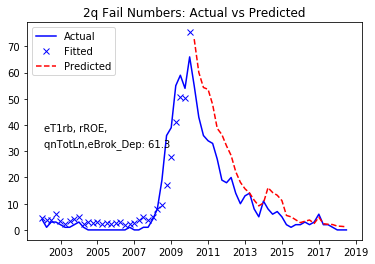

In [53]:
fx = list(fnbr.index)
plt.plot(fx, fnbr['f2'],'b', label='Actual')
plt.plot(fx, fnbr['f2_0f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, fnbr['f2_0p'],'r--',lw=1.5, label='Predicted')
plt.legend(loc=2)
plt.title('2q Fail Numbers: Actual vs Predicted')
plt.annotate(dv4r[dv4r['idx']==0]['Annot1'].values[0], xy=(0.05, 0.5),\
             xycoords='axes fraction', fontsize=10) # var listing annotation
plt.annotate(dv4r[dv4r['idx']==0]['Annot2'].values[0], xy=(0.05, 0.43),\
             xycoords='axes fraction', fontsize=10) # var listing annotation
plt.show()

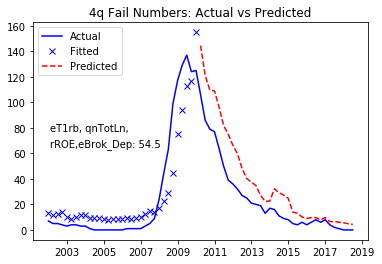

In [54]:
fx = list(fnbr.index)
plt.plot(fx, fnbr['f4'],'b', label='Actual')
plt.plot(fx, fnbr['f4_2f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, fnbr['f4_2p'],'r--',lw=1.5, label='Predicted')
plt.annotate(dv4r[dv4r['idx']==2]['Annot1'].values[0], xy=(0.05, 0.5),\
             xycoords='axes fraction', fontsize=10) # var listing annotation
plt.annotate(dv4r[dv4r['idx']==2]['Annot2'].values[0], xy=(0.05, 0.43),\
             xycoords='axes fraction', fontsize=10) # var listing annotation
plt.legend(loc=2)
plt.title('4q Fail Numbers: Actual vs Predicted')
plt.show()

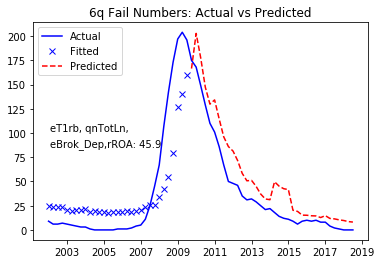

In [55]:
fx = list(fnbr.index)
plt.plot(fx, fnbr['f6'],'b', label='Actual')
plt.plot(fx, fnbr['f6_4f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, fnbr['f6_4p'],'r--',lw=1.5, label='Predicted')
plt.annotate(dv4r[dv4r['idx']==4]['Annot1'].values[0], xy=(0.05, 0.5),\
             xycoords='axes fraction', fontsize=10) # var listing annotation
plt.annotate(dv4r[dv4r['idx']==4]['Annot2'].values[0], xy=(0.05, 0.43),\
             xycoords='axes fraction', fontsize=10) # var listing annotation
plt.legend(loc=2)
plt.title('6q Fail Numbers: Actual vs Predicted')
plt.show()

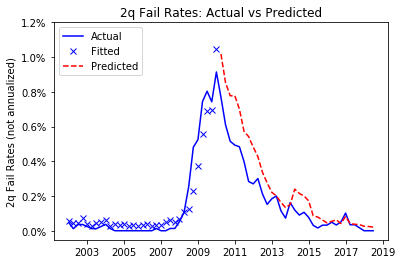

In [56]:
fx = list(fnbr.index)
plt.plot(fx, favg['f2'],'b', label='Actual')
plt.plot(fx, favg['f2_0f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, favg['f2_0p'],'r--',lw=1.5, label='Predicted')
# convert decimals to percentages with % symbols:
ytix = np.arange(0,.0121,.002)  # list of ticks on y-axis
ylbl = ['{:3.1f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('2q Fail Rates (not annualized)')
plt.legend(loc=2)
plt.title('2q Fail Rates: Actual vs Predicted')
plt.show()

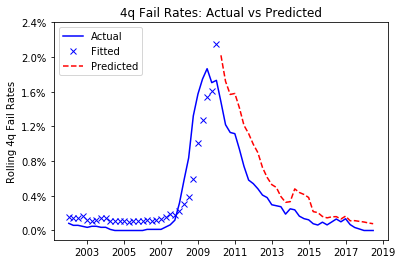

In [57]:
fx = list(fnbr.index)
plt.plot(fx, favg['f4'],'b', label='Actual')
plt.plot(fx, favg['f4_2f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, favg['f4_2p'],'r--',lw=1.5, label='Predicted')
# convert decimals to percentages with % symbols:
ytix = np.arange(0,.0241,.004)  # list of ticks on y-axis
ylbl = ['{:3.1f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Rolling 4q Fail Rates')
plt.legend(loc=2)
plt.title('4q Fail Rates: Actual vs Predicted')
plt.show()

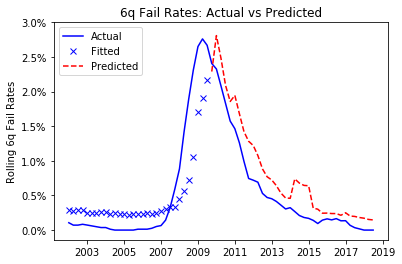

In [58]:
fx = list(fnbr.index)
plt.plot(fx, favg['f6'],'b', label='Actual')
plt.plot(fx, favg['f6_4f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, favg['f6_4p'],'r--',lw=1.5, label='Predicted')
# convert decimals to percentages with % symbols:
ytix = np.arange(0,.0301,.005)  # list of ticks on y-axis
ylbl = ['{:3.1f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Rolling 6q Fail Rates')
plt.legend(loc=2)
plt.title('6q Fail Rates: Actual vs Predicted')
plt.show()

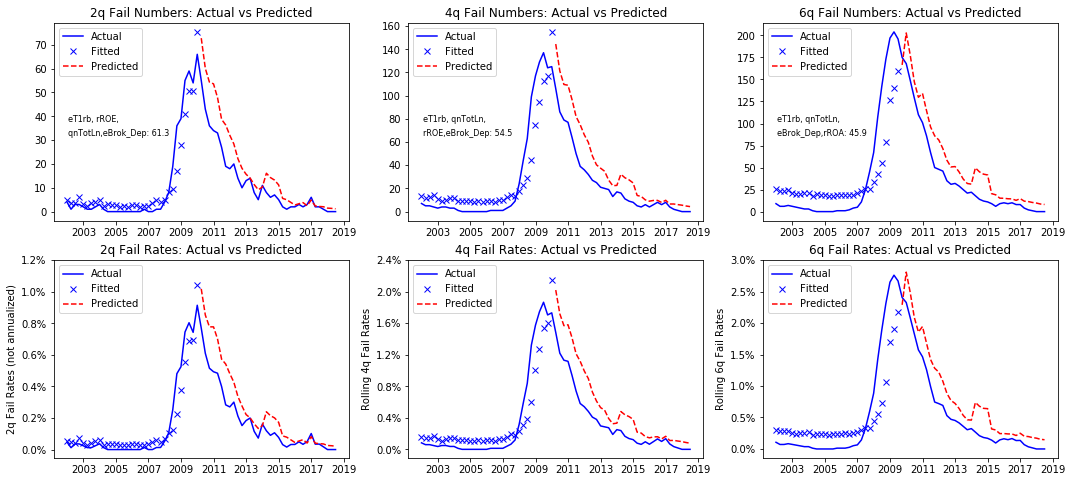

In [59]:
fx = list(fnbr.index)
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*3, plSize[1]*2) )  ## double width, single height

plt.subplot(2, 3, 1)
plt.plot(fx, fnbr['f2'],'b', label='Actual')
plt.plot(fx, fnbr['f2_0f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, fnbr['f2_0p'],'r--',lw=1.5, label='Predicted')
plt.legend(loc=2)
plt.title('2q Fail Numbers: Actual vs Predicted')
plt.annotate(dv4r[dv4r['idx']==0]['Annot1'].values[0], xy=(0.05, 0.5),\
             xycoords='axes fraction', fontsize=8) # var listing annotation
plt.annotate(dv4r[dv4r['idx']==0]['Annot2'].values[0], xy=(0.05, 0.43),\
             xycoords='axes fraction', fontsize=8) # var listing annotation

plt.subplot(2, 3, 2)
plt.plot(fx, fnbr['f4'],'b', label='Actual')
plt.plot(fx, fnbr['f4_2f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, fnbr['f4_2p'],'r--',lw=1.5, label='Predicted')
plt.annotate(dv4r[dv4r['idx']==2]['Annot1'].values[0], xy=(0.05, 0.5),\
             xycoords='axes fraction', fontsize=8) # var listing annotation
plt.annotate(dv4r[dv4r['idx']==2]['Annot2'].values[0], xy=(0.05, 0.43),\
             xycoords='axes fraction', fontsize=8) # var listing annotation
plt.legend(loc=2)
plt.title('4q Fail Numbers: Actual vs Predicted')

plt.subplot(2, 3, 3)
plt.plot(fx, fnbr['f6'],'b', label='Actual')
plt.plot(fx, fnbr['f6_4f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, fnbr['f6_4p'],'r--',lw=1.5, label='Predicted')
plt.annotate(dv4r[dv4r['idx']==4]['Annot1'].values[0], xy=(0.05, 0.5),\
             xycoords='axes fraction', fontsize=8) # var listing annotation
plt.annotate(dv4r[dv4r['idx']==4]['Annot2'].values[0], xy=(0.05, 0.43),\
             xycoords='axes fraction', fontsize=8) # var listing annotation
plt.legend(loc=2)
plt.title('6q Fail Numbers: Actual vs Predicted')

plt.subplot(2, 3, 4)
plt.plot(fx, favg['f2'],'b', label='Actual')
plt.plot(fx, favg['f2_0f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, favg['f2_0p'],'r--',lw=1.5, label='Predicted')
# convert decimals to percentages with % symbols:
ytix = np.arange(0,.0121,.002)  # list of ticks on y-axis
ylbl = ['{:3.1f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('2q Fail Rates (not annualized)')
plt.legend(loc=2)
plt.title('2q Fail Rates: Actual vs Predicted')

plt.subplot(2, 3, 5)
plt.plot(fx, favg['f4'],'b', label='Actual')
plt.plot(fx, favg['f4_2f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, favg['f4_2p'],'r--',lw=1.5, label='Predicted')
# convert decimals to percentages with % symbols:
ytix = np.arange(0,.0241,.004)  # list of ticks on y-axis
ylbl = ['{:3.1f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Rolling 4q Fail Rates')
plt.legend(loc=2)
plt.title('4q Fail Rates: Actual vs Predicted')

plt.subplot(2, 3, 6)
plt.plot(fx, favg['f6'],'b', label='Actual')
plt.plot(fx, favg['f6_4f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, favg['f6_4p'],'r--',lw=1.5, label='Predicted')
# convert decimals to percentages with % symbols:
ytix = np.arange(0,.0301,.005)  # list of ticks on y-axis
ylbl = ['{:3.1f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Rolling 6q Fail Rates')
plt.legend(loc=2)
plt.title('6q Fail Rates: Actual vs Predicted')

plt.savefig('LR_'+alt+str(thresh)+'mm2_2009_nbrvsrate_allmods'+'.png', dpi=400, bbox_inches='tight')

plt.show()

In [60]:
fcol[-6:]

['f2_0', 'f2_1', 'f4_2', 'f4_3', 'f6_4', 'f6_5']

In [61]:
len(dff) # 478607

478607

In [62]:
ffb = dff[dff['FailDate']>'1999'][['IDRSSD','AsOf','Name','FailDate','eTotAst']+fcol[-6:]].groupby(['IDRSSD']).max()

In [63]:
ffb.sort_index(by='eTotAst',ascending=False,inplace=True)
ffb.reset_index(drop=False,inplace=True)

In [64]:
dff.columns

Index([u'IDRSSD', u'AsOf', u'Name', u'State', u'eTotAst', u'rcTotLn',
       u'qnTotLn', u'rNIM', u'rPPNR', u'rROA', u'rROE', u'rEff', u'eLn_Dep',
       u'aFF_TA', u'eBrok_Dep', u'eT1rb', u'eTotrb', u'eALLL_Ln', u'lnTotAst',
       u'FailDate', u'mtf', u'mtf2', u'f2', u'f4', u'f6', u'f8', u'Intercept',
       u'f2_0', u'f2_1', u'f4_2', u'f4_3', u'f6_4', u'f6_5'],
      dtype='object')

In [65]:
ffb.tail()

IDRSSD       AsOf                           Name   FailDate  eTotAst  \
498   901956 2007-12-31                      HUME BANK 2008-03-07  19681.0   
499   587574 2009-12-31  ARCOLA HOMESTEAD SAVINGS BANK 2010-06-04  19083.0   
500   359070 2006-09-30      METROPOLITAN SAVINGS BANK 2007-02-02  15760.0   
501  1861347 2003-06-30           PULASKI SAVINGS BANK 2003-11-14  11051.0   
502   475934 2001-12-31           STATE BANK OF LATHAM 2014-06-20   6470.0   

         f2_0      f2_1      f4_2      f4_3      f6_4      f6_5  
498  0.000674  0.000408  0.002633  0.003232  0.006762  0.005494  
499  0.878686  0.824802  0.966944  0.989417  0.983641  0.962335  
500  0.000249  0.000129  0.000904  0.000952  0.002170  0.002031  
501  0.000272  0.000146  0.001196  0.000922  0.002351  0.002741  
502  0.000032  0.000014  0.000151  0.000079  0.000284  0.000437

In [66]:
ffb['Rank'] = ffb['eTotAst'].rank(ascending=False)
ffb.head()

IDRSSD       AsOf                         Name   FailDate       eTotAst  \
0   480228 2018-06-30          BANK OF AMERICA, NA 2009-01-16  1.765242e+09   
1   476810 2018-06-30               CITIBANK, N.A. 2008-11-23  1.407297e+09   
2  1830035 2014-09-30        MBNA AMERICA BANK, NA 2009-01-16  1.967486e+08   
3   486752 2011-03-31  CITIBANK (SOUTH DAKOTA), NA 2008-11-23  1.579352e+08   
4  1469211 2006-12-31            TREASURY BANK, NA 2009-01-16  9.328420e+07   

       f2_0      f2_1      f4_2      f4_3      f6_4      f6_5  Rank  
0  0.001353  0.021971  0.004574  0.006024  0.011493  0.009482   1.0  
1  0.001466  0.022469  0.005379  0.006858  0.012897  0.010796   2.0  
2  0.000785  0.005346  0.006153  0.065822  0.158528  0.014032   3.0  
3  0.024537  0.007372  0.129530  0.122853  0.249394  0.255562   4.0  
4  0.000863  0.002667  0.003389  0.003745  0.008264  0.007528   5.0

In [67]:
dff[dff['mtf']>0][['IDRSSD','mtf']].head(6)

IDRSSD         mtf
1145    2451  102.704368
1146    2451   99.747428
1147    2451   96.757634
1148    2451   93.734984
1149    2451   90.712335
1150    2451   87.755395

In [68]:
############### CAUTION  CAUTION #########################################
## DO NOT RUN UNLESS.....
## short-cut to skip all earlier processing!!!!!!!!!!!!!!!!!
############### CAUTION  CAUTION #########################################

#dff = pd.read_csv('allbanks_f2468_roe0mm2_20091231.csv', index_col=0)
#dff['AsOf'] = pd.to_datetime(dff['AsOf'])
#dff['FailDate'] = pd.to_datetime(dff['FailDate'])
############### CAUTION  CAUTION #########################################

fcol = [x for x in list(dff.columns) if x[0:1]=='f']
xcol=['rcTotLn','qnTotLn','rNIM','rPPNR','rROA','rROE','rEff','eLn_Dep','aFF_TA','eBrok_Dep','eT1rb','eTotrb','eALLL_Ln','lnTotAst']
dmtf=dff[dff['mtf2']>0][['mtf2']+xcol+fcol].groupby('mtf2').mean()
targ = pd.to_datetime('2009-12-31')
thresh = 0
alt = 'roe' ## or alt = ''  # add rROE >=-200 screening test

dff.head(2)

IDRSSD       AsOf                    Name State  eTotAst   rcTotLn  \
0      37 2001-12-31  BANK OF HANCOCK COUNTY    GA  66624.0  0.320412   
1      37 2002-03-31  BANK OF HANCOCK COUNTY    GA  68766.0  0.261846   

    qnTotLn      rNIM     rPPNR      rROA    ...     f4  f6  f8  Intercept  \
0  0.202341  4.771308  2.035791  1.366385    ...      0   0   0        1.0   
1  0.199812  4.673793  1.952308  1.314604    ...      0   0   0        1.0   

           f2_0          f2_1          f4_2          f4_3          f6_4  \
0  2.057203e-08  2.715938e-08  3.110231e-07  1.900500e-08  3.771580e-07   
1  2.345935e-08  3.112617e-08  3.486561e-07  2.219058e-08  4.278112e-07   

       f6_5  
0  0.000002  
1  0.000002  

[2 rows x 33 columns]

In [69]:
dmtf.head()

rcTotLn    qnTotLn      rNIM     rPPNR      rROA        rROE  \
mtf2                                                                  
1.0   3.937991  14.068449  2.747658 -1.028706 -4.421288 -116.364054   
2.0   3.968880  13.388600  3.061297 -0.992109 -4.567074 -107.884175   
3.0   4.298960  14.221545  2.645307 -1.208242 -4.803204 -110.383827   
4.0   4.012591  13.710804  2.735300 -0.872279 -4.734224 -101.089091   
5.0   3.800015  12.616803  3.144306 -0.687285 -4.416901  -86.473430   

              rEff    eLn_Dep    aFF_TA  eBrok_Dep    ...      f2   f4   f6  \
mtf2                                                  ...                     
1.0    6459.856915  78.133505  9.195334  12.624332    ...     1.0  1.0  1.0   
2.0   14108.183455  78.239031  8.802256  10.210141    ...     1.0  1.0  1.0   
3.0    2895.102951  77.313557  7.531037  10.558283    ...     1.0  1.0  1.0   
4.0    8531.716387  84.368445  7.934190  13.397335    ...     1.0  1.0  1.0   
5.0   11293.392125  80.017769  7.764345  10.511195    ...     1.0  1.0  1.0   

       f8      f2_0      f2_1      f4_2      f4_3      f6_4      f6_5  
mtf2                                                                   
1.0   1.0  0.597340  0.614139  0.758544  0.673074  0.702844  0.791737  
2.0   1.0  0.549952  0.567901  0.729059  0.645486  0.678682  0.764328  
3.0   1.0  0.528936  0.547078  0.730536  0.650380  0.694520  0.776235  
4.0   1.0  0.478243  0.489938  0.684290  0.617825  0.665108  0.734495  
5.0   1.0  0.356300  0.375291  0.581105  0.524885  0.585129  0.646113  

[5 rows x 24 columns]

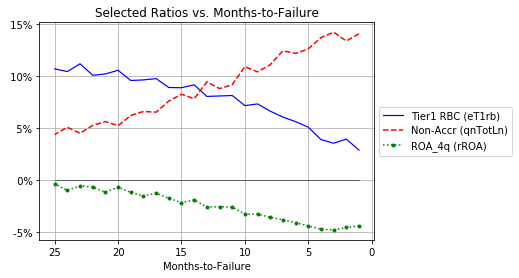

In [70]:
xm = list(dmtf.index)[0:25]
#dmtf.ix[0:25][['rcTotLn','qnTotLn','rROA','eT1rb']].plot()
plt.plot(xm,dmtf.ix[0:25]['eT1rb'],c='b',ls='-',lw=1.2,label='Tier1 RBC (eT1rb)')
plt.plot(xm,dmtf.ix[0:25]['qnTotLn'],c='r',ls='--',label='Non-Accr (qnTotLn)')
#plt.plot(xm,dmtf.ix[0:25]['rcTotLn'],c='b',label='NCO TotLn (r4q)')
plt.plot(xm,dmtf.ix[0:25]['rROA'],c='g',ls=':',lw=1.5,marker='.',label='ROA_4q (rROA)')
#plt.plot(xm,dmtf.ix[0:25]['eBrok_Dep'],c='g',ls='-.',lw=1.5,marker='x',label='Brok%Dep')
plt.plot(xm,[0]*25,'k',lw=.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ytix = np.arange(-5,15.1,5)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.xlabel('Months-to-Failure')
plt.grid()
plt.title("Selected Ratios vs. Months-to-Failure")
plt.gca().invert_xaxis()  ## inverts x-axis!!
plt.savefig('LR_'+alt+str(thresh)+'mm2_2009_ratiosvsmtf'+'.png', dpi=300, bbox_inches='tight')
plt.show()

In [71]:
xm

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0]

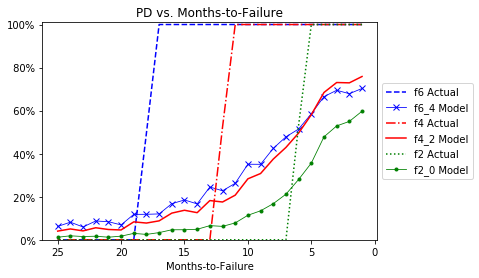

In [72]:
falt = ['f2_0','f4_2','f6_4']
#dmtf.ix[0:25][falt].plot()
plt.plot(xm,dmtf.ix[0:25]['f6'],c='b',ls='--',lw=1.5,label='f6 Actual')
plt.plot(xm,dmtf.ix[0:25]['f6_4'],c='b',ls='-',lw=.8,marker='x',label='f6_4 Model')
plt.plot(xm,dmtf.ix[0:25]['f4'],c='r',ls='-.',lw=1.5,label='f4 Actual')
plt.plot(xm,dmtf.ix[0:25]['f4_2'],c='r',lw=1.5,label='f4_2 Model')
plt.plot(xm,dmtf.ix[0:25]['f2'],c='g',ls=':',lw=1.5,label='f2 Actual')
plt.plot(xm,dmtf.ix[0:25]['f2_0'],c='g',ls='-',lw=.8,marker='.',label='f2_0 Model')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("PD vs. Months-to-Failure")
plt.ylim([0,1.01])
ytix = np.arange(0,1.1,.2)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.xlabel('Months-to-Failure')
plt.gca().invert_xaxis()
plt.savefig('LR_'+alt+str(thresh)+'mm2_2009_pdsvsmtf'+'.png', dpi=300, bbox_inches='tight')
plt.show()

In [73]:
varlst = ['qnTotLn', 'rROA', 'rROE','eBrok_Dep', 'eT1rb','lnTotAst']
varlst

['qnTotLn', 'rROA', 'rROE', 'eBrok_Dep', 'eT1rb', 'lnTotAst']

In [74]:
df11=dff[(dff['AsOf']=='2010-12-31')&(dff['FailDate']>'2011-01-01')&(dff['FailDate']<'2012-01-01')]
df11.sort_index(by='FailDate',inplace=True)
len(df11) # 77

77

In [75]:
df11[['FailDate','Name','State','f2_0','f4_2','f6_4']][0:15]

FailDate                               Name State      f2_0  \
464097 2011-01-07                        LEGACY BANK    AZ  0.383892   
180389 2011-01-21         ENTERPRISE BANKING COMPANY    GA  0.911389   
20131  2011-01-28              FIRST STATE BANK, THE    OK  0.000587   
456884 2011-01-28                      FIRSTIER BANK    CO  0.981773   
86036  2011-01-28               FIRST COMMUNITY BANK    NM  0.874545   
467017 2011-02-04     COMMUNITY FIRST BANK - CHICAGO    IL  0.211593   
455614 2011-02-04                AMERICAN TRUST BANK    GA  0.928994   
437869 2011-02-04                 NORTH GEORGIA BANK    GA  0.972357   
276783 2011-02-11                 PEOPLES STATE BANK    MI  0.947522   
418903 2011-02-11               CANYON NATIONAL BANK    CA  0.719009   
78972  2011-02-11                  BADGER STATE BANK    WI  0.173843   
440728 2011-02-11      SUNSHINE STATE COMMUNITY BANK    FL  0.893630   
98476  2011-02-18                     HABERSHAM BANK    GA  0.862702   
413709 2011-02-18         CITIZENS BANK OF EFFINGHAM    GA  0.883514   
353203 2011-03-11  FIRST NATIONAL BANK OF DAVIS, THE    OK  0.000473   

            f4_2      f6_4  
464097  0.683632  0.344654  
180389  0.987159  0.980220  
20131   0.001760  0.004601  
456884  0.997407  0.970558  
86036   0.976790  0.870044  
467017  0.494868  0.353113  
455614  0.987660  0.914250  
437869  0.996302  0.975948  
276783  0.989779  0.912745  
418903  0.926240  0.760914  
78972   0.436946  0.345973  
440728  0.982214  0.888240  
98476   0.973610  0.909108  
413709  0.976390  0.872473  
353203  0.002585  0.006058

In [76]:
df11[fcol].mean()

f2      0.441558
f4      1.000000
f6      1.000000
f8      1.000000
f2_0    0.430008
f2_1    0.459681
f4_2    0.659813
f4_3    0.586624
f6_4    0.642687
f6_5    0.723790
dtype: float64

In [77]:
df11.to_csv("2011failedbks_pds_20091231_"+alt+str(thresh)+"mm2.csv")

In [78]:
db11=dff[(dff['AsOf']=='2010-12-31')]
db11.sort_index(by='eTotAst',ascending=False,inplace=True)
db11[['Name']+fcol].head(10)

Name  f2  f4  f6  f8      f2_0      f2_1  \
315721       JPMORGAN CHASE BANK, NA   0   0   0   0  0.000820  0.014456   
177711           BANK OF AMERICA, NA   0   0   0   0  0.000529  0.008420   
175815                CITIBANK, N.A.   0   0   0   0  0.000060  0.001051   
165988          WELLS FARGO BANK, NA   0   0   0   0  0.000587  0.008990   
186998                  U.S. BANK NA   0   0   0   0  0.000842  0.008605   
302595                  PNC BANK, NA   0   0   0   0  0.000276  0.002791   
392018         FIA CARD SERVICES, NA   0   0   0   0  0.000071  0.000398   
199925  BANK OF NEW YORK MELLON, THE   0   0   0   0  0.000244  0.002337   
152426             HSBC BANK USA, NA   0   0   0   0  0.000217  0.001738   
183923                 TD BANK, N.A.   0   0   0   0  0.000255  0.000960   

            f4_2      f4_3      f6_4      f6_5  
315721  0.003104  0.003738  0.008295  0.007157  
177711  0.002232  0.002107  0.005300  0.005426  
175815  0.000332  0.000184  0.000726  0.001033  
165988  0.002252  0.002254  0.005158  0.005174  
186998  0.002873  0.003402  0.006709  0.006040  
302595  0.001203  0.000945  0.002601  0.003049  
392018  0.000402  0.000190  0.000732  0.001193  
199925  0.000967  0.000880  0.002202  0.002302  
152426  0.000996  0.000780  0.002296  0.002635  
183923  0.001532  0.000876  0.003192  0.004481

In [79]:
db11.to_csv("2011allbks_pds_20101231_"+alt+str(thresh)+"mm2.csv")

In [80]:
len(dff) # 478607

478607

In [81]:
varlst = ['qnTotLn', 'rROA', 'rROE','eBrok_Dep', 'eT1rb','lnTotAst']
varlst

['qnTotLn', 'rROA', 'rROE', 'eBrok_Dep', 'eT1rb', 'lnTotAst']

In [82]:
dff.to_csv("allbanks_f2468_"+alt+str(thresh)+"mm2_"+str(targ.year)+str(targ.month)+str(targ.day)+".csv")

In [83]:
"allbanks_f2468_"+alt+str(thresh)+"mm2_"+str(targ.year)+str(targ.month)+str(targ.day)+".csv"

'allbanks_f2468_roe0mm2_20091231.csv'

In [84]:
dfr.columns

Index([u'IDRSSD', u'AsOf', u'Name', u'State', u'eTotAst', u'rcTotLn',
       u'qnTotLn', u'rNIM', u'rPPNR', u'rROA', u'rROE', u'rEff', u'eLn_Dep',
       u'aFF_TA', u'eBrok_Dep', u'eT1rb', u'eTotrb', u'eALLL_Ln', u'lnTotAst',
       u'FailDate', u'mtf', u'mtf2', u'f2', u'f4', u'f6', u'f8'],
      dtype='object')

In [85]:
len(dfr), len(dff) # 489288, 478607

(489288, 478607)

In [86]:
len(dfh) # 259210

259210

In [87]:
dfh.to_csv("modeldata_f2468_"+alt+str(thresh)+"mm2_"+str(targ.year)+str(targ.month)+str(targ.day)+".csv")

In [88]:
"modeldata_f2468_"+alt+str(thresh)+"mm2_"+str(targ.year)+str(targ.month)+str(targ.day)+".csv"

'modeldata_f2468_roe0mm2_20091231.csv'

In [89]:
dfh.head(2)

IDRSSD       AsOf                    Name FailDate  f2  f4  f6  f8  \
0      37 2001-12-31  BANK OF HANCOCK COUNTY      NaT   0   0   0   0   
1      37 2002-03-31  BANK OF HANCOCK COUNTY      NaT   0   0   0   0   

    rcTotLn   qnTotLn    ...         eT1rb     eTotrb  eALLL_Ln   lnTotAst  \
0  0.320412  0.202341    ...     31.394061  32.659950  2.377511  11.106820   
1  0.261846  0.199812    ...     31.128485  32.396358  2.522930  11.138465   

           f2_0          f2_1          f4_2          f4_3          f6_4  \
0  2.057203e-08  2.715938e-08  3.110231e-07  1.900500e-08  3.771580e-07   
1  2.345935e-08  3.112617e-08  3.486561e-07  2.219058e-08  4.278112e-07   

       f6_5  
0  0.000002  
1  0.000002  

[2 rows x 28 columns]

In [90]:
dv4b

idx  fx     v1        r1       v2        r2         v3        r3         v4  \
0   0  f2  eT1rb  0.522124     rROE  0.574443    qnTotLn  0.598190  eBrok_Dep   
1   0  f2  eT1rb  0.522124     rROE  0.574443    qnTotLn  0.598190   lnTotAst   
2   3  f4  eT1rb  0.397605  qnTotLn  0.484993       rROE  0.519180  eBrok_Dep   
3   2  f4  eT1rb  0.397605  qnTotLn  0.484993       rROA  0.519780  eBrok_Dep   
4   4  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118       rROA   
5   4  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118       rROE   

         r4       Int        c1        c2        c3        c4  
0  0.613496 -2.811250 -0.468572 -0.025504  0.085620  0.034020  
1  0.607906 -6.580815 -0.447084 -0.029117  0.085405  0.306157  
2  0.544649 -2.212065 -0.400399  0.112586 -0.029288  0.040636  
3  0.541573 -0.917821 -0.524381  0.118437 -0.309044  0.038061  
4  0.459248 -1.259899 -0.419314  0.147909  0.041358 -0.290305  
5  0.458956 -2.072620 -0.342553  0.140668  0.042746 -0.026573

In [91]:
fcol

['f2', 'f4', 'f6', 'f8', 'f2_0', 'f2_1', 'f4_2', 'f4_3', 'f6_4', 'f6_5']

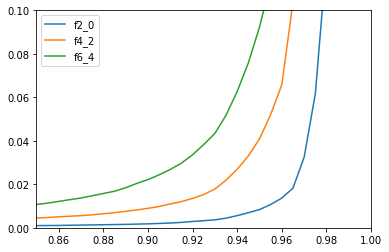

In [92]:
dpc0912 = dff[dff['AsOf']=='2009-12-31'][fcol[-6:]].quantile(np.arange(.01,1,.005))
dpc0912[['f2_0','f4_2','f6_4']].plot()
plt.ylim([0,.1])
plt.xlim([.85,1])
plt.legend(loc=2)

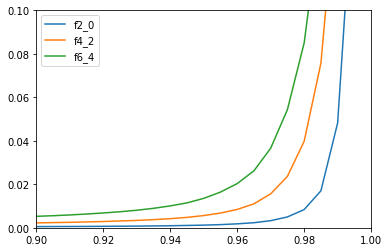

In [93]:
dpc0914 = dff[dff['AsOf']>'2009-01-01'][fcol[-6:]].quantile(np.arange(.01,1,.005))
dpc0914[['f2_0','f4_2','f6_4']].plot()
plt.ylim([0,.1])
plt.xlim([.9,1])
plt.legend(loc=2)

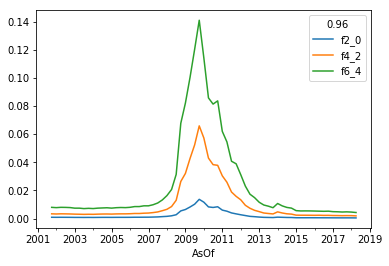

In [94]:
dpc96 = dff[['AsOf']+fcol[-6:]].groupby('AsOf').quantile(.96)
dpc96[['f2_0','f4_2','f6_4']].plot()

In [95]:
dpc90p = dff[['AsOf']+fcol[-6:]].groupby('AsOf').quantile([.9,.92,.94,.96,.98])
dpc90p = dpc90p.unstack(1)
#dpc90p=dpc90p.swaplevel(0,1,axis=1)
dpc90p.sort_index(axis=1,inplace=True)
dpc90p.head(2)

f2_0                                              f2_1  \
                0.90      0.92      0.94      0.96      0.98      0.90   
AsOf                                                                     
2001-12-31  0.000606  0.000668  0.000774  0.000953  0.001395  0.000669   
2002-03-31  0.000588  0.000663  0.000757  0.000920  0.001399  0.000646   

                                                      ...         f6_4  \
                0.92      0.94      0.96      0.98    ...         0.90   
AsOf                                                  ...                
2001-12-31  0.000755  0.000874  0.001107  0.001656    ...     0.005004   
2002-03-31  0.000724  0.000838  0.001064  0.001582    ...     0.004905   

                                                        f6_5            \
                0.92      0.94      0.96      0.98      0.90      0.92   
AsOf                                                                     
2001-12-31  0.005557  0.006366  0.007997  0.012124  0.004450  0.004927   
2002-03-31  0.005552  0.006407  0.007798  0.012029  0.004437  0.004945   

                                          
                0.94      0.96      0.98  
AsOf                                      
2001-12-31  0.005626  0.006960  0.010645  
2002-03-31  0.005682  0.006936  0.010818  

[2 rows x 30 columns]

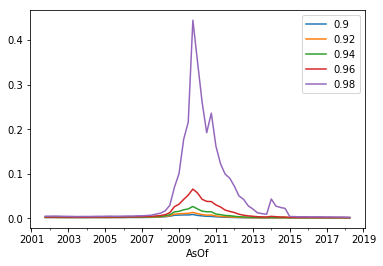

In [96]:
dpc90p['f4_2'].plot()

In [97]:
dfr0916 = dfr[dfr['AsOf']>'2009-01-01']
len(dfr0916) # 253610

253610

In [98]:
dfr.columns

Index([u'IDRSSD', u'AsOf', u'Name', u'State', u'eTotAst', u'rcTotLn',
       u'qnTotLn', u'rNIM', u'rPPNR', u'rROA', u'rROE', u'rEff', u'eLn_Dep',
       u'aFF_TA', u'eBrok_Dep', u'eT1rb', u'eTotrb', u'eALLL_Ln', u'lnTotAst',
       u'FailDate', u'mtf', u'mtf2', u'f2', u'f4', u'f6', u'f8'],
      dtype='object')

In [99]:
dfr0916.sort_index(by=['AsOf','eTotAst'],ascending=[True,False],inplace=True)
dfr0916.reset_index(drop=True,inplace=True)
dfr0916.tail(2)

IDRSSD       AsOf                              Name State  eTotAst  \
253608  2337335 2018-06-30              UMB BANK & TRUST, NA    MO   3030.0   
253609  1377521 2018-06-30  MERCHANTS BANK OF CALIFORNIA, NA    CA    821.0   

        rcTotLn  qnTotLn        rNIM      rPPNR       rROA ...      eTotrb  \
253608      0.0      0.0  500.000000   0.165139   0.099083 ...  102.993197   
253609     -0.5      0.0    3.898756 -26.401229 -25.661924 ...  225.977654   

        eALLL_Ln  lnTotAst  FailDate  mtf  mtf2  f2  f4  f6 f8  
253608       0.0  8.016318       NaT  NaN   NaN   0   0   0  0  
253609       0.0  6.710523       NaT  NaN   NaN   0   0   0  0  

[2 rows x 26 columns]

In [100]:
dfr0916.to_csv("allbanks_f2468r_"+alt+str(thresh)+"mm2_2009_201806"+".csv")

In [101]:
dfr0916.tail()

IDRSSD       AsOf                                           Name  \
253605  3952904 2018-06-30  CANANDAIGUA NATIONAL TRUST COMPANY OF FLORIDA   
253606  2960788 2018-06-30              WHEATON COLLEGE TRUST COMPANY, NA   
253607  3268173 2018-06-30                       EMIGRANT MERCANTILE BANK   
253608  2337335 2018-06-30                           UMB BANK & TRUST, NA   
253609  1377521 2018-06-30               MERCHANTS BANK OF CALIFORNIA, NA   

       State  eTotAst  rcTotLn  qnTotLn        rNIM      rPPNR       rROA ...  \
253605    FL   3710.0      0.0      0.0    0.502773  -2.276114  -1.815472 ...   
253606    IL   3501.0      0.0      0.0    1.423825   2.538401   1.846109 ...   
253607    NY   3434.0      0.0      0.0    1.048569  -0.610376  -0.406918 ...   
253608    MO   3030.0      0.0      0.0  500.000000   0.165139   0.099083 ...   
253609    CA    821.0     -0.5      0.0    3.898756 -26.401229 -25.661924 ...   

             eTotrb  eALLL_Ln  lnTotAst  FailDate  mtf  mtf2  f2  f4  f6 f8  
253605   527.625899       0.0  8.218787       NaT  NaN   NaN   0   0   0  0  
253606  3010.909091       0.0  8.160804       NaT  NaN   NaN   0   0   0  0  
253607   425.872093       0.0  8.141481       NaT  NaN   NaN   0   0   0  0  
253608   102.993197       0.0  8.016318       NaT  NaN   NaN   0   0   0  0  
253609   225.977654       0.0  6.710523       NaT  NaN   NaN   0   0   0  0  

[5 rows x 26 columns]

In [102]:
dff0916 = dff[dff['AsOf']>'2009-01-01']
len(dff0916) # 248622

248622

In [103]:
dff0916.sort_index(by=['AsOf','eTotAst'],ascending=[True,False],inplace=True)
dff0916.reset_index(drop=True,inplace=True)
dff0916.head(2)

IDRSSD       AsOf                     Name State       eTotAst   rcTotLn  \
0  852218 2009-03-31  JPMORGAN CHASE BANK, NA    OH  1.688164e+09  1.373904   
1  480228 2009-03-31      BANK OF AMERICA, NA    NC  1.432862e+09  1.475853   

    qnTotLn      rNIM     rPPNR      rROA    ...     f4  f6  f8  Intercept  \
0  2.496176  2.523947  1.918733  0.699537    ...      0   0   0        1.0   
1  3.152932  2.483742  1.831558  0.455510    ...      0   0   0        1.0   

       f2_0      f2_1      f4_2      f4_3      f6_4      f6_5  
0  0.000950  0.016343  0.003298  0.004195  0.008275  0.006959  
1  0.001321  0.021859  0.004574  0.006024  0.011493  0.009482  

[2 rows x 33 columns]

In [104]:
dff0916.to_csv("allbanks_f2468_"+alt+str(thresh)+"mm2_2009_201806"+".csv")

In [105]:
dff201806 = dff[dff['AsOf']=='2018-6-30']
len(dff201806) # 5527

5527

In [106]:
dff201806.to_csv("allbanks_f2468r_"+alt+str(thresh)+"mm2_201806"+".csv")

In [107]:
"allbanks_f2468r_"+alt+str(thresh)+"mm2_201806"+".csv"

'allbanks_f2468r_roe0mm2_201806.csv'

In [108]:
dff201806.tail()

IDRSSD       AsOf                            Name State    eTotAst  \
489256  4845861 2018-06-30                    PRIMARY BANK    NH   178905.0   
489265  5050028 2018-06-30  INTERNATIONAL BANK OF COMMERCE    OK  1559508.0   
489269  5082382 2018-06-30             BANK OF AUSTIN, THE    TX    99951.0   
489275  5086072 2018-06-30                  BLUE GATE BANK    CA   121841.0   
489281  5143788 2018-06-30       WINTER PARK NATIONAL BANK    FL   188809.0   

         rcTotLn  qnTotLn      rNIM      rPPNR       rROA      ...       f4  \
489256  0.000000  0.00000  3.134475   0.557806   0.087969      ...        0   
489265  0.112062  0.32183  3.792011   1.743767   1.188098      ...        0   
489269  0.000000  0.00000  3.105000 -10.222422 -11.128985      ...        0   
489275  0.000000  0.00000  2.254763  -3.017335  -3.404005      ...        0   
489281  0.000000  0.00000  2.661222  -1.065356  -2.163242      ...        0   

        f6  f8  Intercept          f2_0          f2_1          f4_2  \
489256   0   0        1.0  4.133635e-05  3.749618e-05  2.460337e-04   
489265   0   0        1.0  7.166581e-05  1.698524e-04  3.288353e-04   
489269   0   0        1.0  1.103803e-10  2.438777e-10  4.493241e-09   
489275   0   0        1.0  9.852541e-08  1.639163e-07  1.417850e-06   
489281   0   0        1.0  1.558404e-08  3.065519e-08  2.706860e-07   

                f4_3          f6_4          f6_5  
489256  1.138862e-04  4.669948e-04  7.451926e-04  
489265  1.926400e-04  6.104863e-04  8.748777e-04  
489269  1.046641e-09  6.300693e-08  6.253960e-08  
489275  2.344004e-07  3.418113e-06  8.504897e-06  
489281  2.752694e-08  5.843813e-07  2.029368e-06  

[5 rows x 33 columns]